# Supplement B
# Drop Size Distribution retrieval


In the following, we introduce the use of the pyOptimalEstimation Python library using a radar-based drop-size distribution (DSD) retrieval as an example. 
\citep{williams_describing_2014} suggested to parameterize a DSD using a scaling parameter $N_w$ as well as the raindrop mass spectrum mean diameter $D_m$ and its standard deviation $\sigma_m$.
Assuming that the DSD follows a gamma distribution, $\sigma_m$ is related to the shape parameter $\mu$ with 
\begin{equation} 
    \mu = (D_m/\sigma)^2 -4
\end{equation}
and we reconstruct the original DSD $N(D)$ as a function of maximum dimension $D$ with
\begin{equation}
    N(D) = N_w \frac{6}{256} \frac{(4+\mu)^{\mu+4}}{\Gamma(\mu+4)} \Big(\frac{D}{D_m}\Big)^{\mu} \exp \Big[ -(4+\mu) \frac{D}{D_m}\Big]
\end{equation}
using the normalization approach by \citet{testud_concept_2001}.

\citet{williams_describing_2014} analyzed the correlations between $D_m$ and $\sigma_m$ in  detail and proposed to use a modified quantity $\sigma_m\!'$ defined with 
\begin{equation}
    \sigma_m\!' = \sigma_m D_m^{-1.36}
\end{equation}
in order to minimize the correlation to $D_m$. The three parameters required to estimate the DSD ($N_w$, $D_m$, and $\sigma_m$ or $\sigma_m\!'$) will form our state vector $\mathbf{x}$. 


A radar simulator will use $\mathbf{x}$ to estimate the measurement vector $\mathbf{y}$ consisting of the radar reflectivity factor ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$) with 
    \begin{equation}
    Z_e = 10 \times \log_{10} (10^{18} \times \sum_i N(D_i) \times \frac{\lambda^4}{|K_w|^2 \pi^5} \times \sigma(D_i) \times \Delta D ) 
    \end{equation}  
and
        \begin{equation}
V_d = \frac{\sum_i v(D_i) \times N(D_i) \times  \sigma(D_i) \times \Delta D}{\sum_i N(D_i) \times  \sigma(D_i) \times \Delta D}
    \end{equation}
where $i$ the index of the discrete DSD and $\sigma$ and $v$ are the functions to describe backscattering cross section and fall velocity, respectively. This means we have two measurements to derive three quantities of the state space, i.e. the problem is not unambiguous. 
In order to obtain the required prior data set, we use the Huntsville data set introduced in \citep{williams_describing_2014} which consists of 18969 individual DSD distributions obtained at Huntsville, AL from December 2009 to October 2011. For every DSD, \citet{williams_describing_2014} determined $N_w$, $D_m$, and $\sigma_m$ and we determine the a-priori assumption $\mathbf{x}_a$ and uncertainty ($\mathbb{S}_a$) form the mean and the covariance of the data set, respectively. 

This example has been developed using Python 3.6, Numpy 1.16.2, Matpolotlib 3.0.3, Scipy 1.2.1, Xarray 0.11.3, Pandas 0.24.1, Seaborn 0.9.0 and Uncertainties 3.0.3

All grey code blocks (cells) in this example can be modified for playing around. Each cell is executed with *shift+enter*. If you have never used Jupyter notebooks before, we recommend to check out the official tutorial: https://mybinder.org/v2/gh/ipython/ipython-in-depth/master?filepath=binder/Index.ipynb


# Installation 
In order to design a retrieval with pyOptimalEstimation, we need to install the library first with 
~~~~  
pip install pyOptimalEstimation
~~~~ 
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray libraries. For development, we used Numpy 1.16.2, Matpolotlib 3.0.3, Scipy 1.2.1, Xarray 0.11.3, Pandas 0.24.1, Seaborn 0.9.0 and Uncertainties 3.0.3. 

The radar simulations are done with the Passive and Active Microwave radiative TRAnsfer model (PAMTRA) \citep{maahn_how_2015}. Here, we use version 2 that is in active development, so we install a specific version with:
~~~~ 
pip install git+git://github.com/maahn/pamtra2.git@461b711ae366b791665687de5dec37abd7ab78f5
~~~~ 



# Preparation

We start with loading the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pn
import xarray as xr
import uncertainties.unumpy as unp
import seaborn as sns

import pamtra2

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')
abc = 'abcdefghijk'

We put some helper routines in a separate file which we load with 

In [2]:
import sys
sys.path.append('lib')
import supporting_routines
from importlib import reload
reload(supporting_routines)

<module 'supporting_routines' from 'lib/supporting_routines.py'>

## State vector


In order to load the required prior data set, we load the Huntsville data set of \citep{williams_describing_2014} from a netCDF file using xarray:

In [3]:
rainDat = xr.open_dataset('data/huntsville_parameters.nc')

and add logarithmic variables with

In [4]:
rainDat['Nw_log10'] = np.log10(rainDat['Nw'])
rainDat['Dm_log10'] = np.log10(rainDat['Dm'])
rainDat['Sm_log10'] = np.log10(rainDat['Sm'])
rainDat['Smprime_log10'] = np.log10(rainDat['Smprime'])

rainDat

<xarray.Dataset>
Dimensions:        (time: 18969)
Coordinates:
  * time           (time) datetime64[ns] 2009-12-13T04:24:00 ... 2011-04-04T21:51:00
Data variables:
    Dm             (time) float64 1.117 1.003 1.014 1.112 ... 1.377 1.475 1.476
    Z              (time) float64 ...
    Nw             (time) float64 2.328e+03 4.55e+03 ... 3.125e+03 1.156e+03
    Sm             (time) float64 0.3556 0.2533 0.2561 ... 0.5925 0.5747 0.5636
    Smprime        (time) float64 0.3058 0.2524 0.2513 ... 0.3837 0.3386 0.3318
    Nw_log10       (time) float64 3.367 3.658 4.037 3.925 ... 3.581 3.495 3.063
    Dm_log10       (time) float64 0.04817 0.001143 0.00605 ... 0.1689 0.1692
    Sm_log10       (time) float64 -0.449 -0.5964 -0.5916 ... -0.2406 -0.249
    Smprime_log10  (time) float64 -0.5145 -0.598 -0.5999 ... -0.4703 -0.4791

We use 100 randomly chosen DSDs for the test data set and use the remaining DSDs for the training data set, i.e. to develop the retrieval.

In [5]:
nTest = 100

np.random.seed(10)
ii = np.arange(len(rainDat.time))
np.random.shuffle(ii)
testII, trainingII = ii[:nTest], ii[nTest:]

rainDat_test = rainDat.isel(time=testII)
rainDat_training = rainDat.isel(time=trainingII)

In order to asses the assumptions that the state variables follow a Gaussian distribution, we make QQ plots. Comparison of the first and second column reveals that a logarithmic state vector $\mathbf{x}$ is much closer to a Gaussian distribution than the linear version. Using a normalized  $\sigma_m\!'$ instead of $\sigma_m$ (third column) changes the the QQ plot only slightly. 

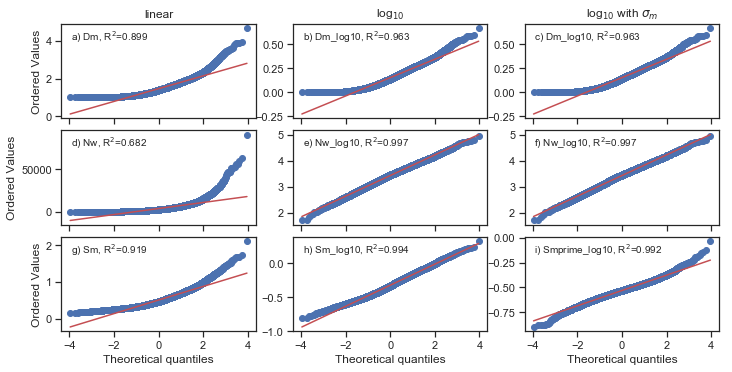

In [6]:
fig, sps = plt.subplots(figsize=(10, 5), nrows=3, ncols=3, sharex=True)
sps = sps.reshape((3, 3))

jj = 0

for kk in range(3):
    for ii, (x_name, x_vars) in enumerate([
        ('linear', ['Dm', 'Nw', 'Sm']),
        ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Sm_log10']),
        ('log$_{10}$ with $\sigma_m\!$',
         ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
    ]):

        x_var = x_vars[kk]

        (osm, osr), (slope, intercept, r) = stats.probplot(
            rainDat_training[x_var],
            dist="norm",
            plot=sps[kk, ii],
            fit=True,
            rvalue=False)

        if kk > 0:
            sps[kk, ii].set_title('')
        else:
            sps[kk, ii].set_title(x_name)

        sps[kk, ii].text(
            0.05,
            0.95,
            '%s) %s, R$^2$=%.3g' % (abc[jj], x_var, r**2),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, ii].transAxes)
        if kk < 2:
            sps[kk, ii].set_xlabel("")
        if ii > 0:
            sps[kk, ii].set_ylabel("")
        jj += 1

fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.)
fig.savefig('qq_x_lin_log.pdf')

The prior $\mathbf{x}_{a}$ and covariance $\mathbb{S}_a$ of the state vector are estimated from the training data set. For convenience, we estimate it for the linear and logarithmic variables together and select the required quantities later. 

In [7]:
S_a = rainDat_training.to_dataframe().cov()
x_ap = rainDat_training.to_dataframe().mean()
print(x_ap)
print(S_a)

Dm                  1.461640
Z                  30.182973
Nw               4054.575495
Sm                  0.508677
Smprime             0.299574
Nw_log10            3.436274
Dm_log10            0.153298
Sm_log10           -0.321980
Smprime_log10      -0.530466
dtype: float64
                       Dm            Z            Nw          Sm    Smprime  \
Dm               0.128514     1.932112 -4.313570e+02    0.060745  -0.000075   
Z                1.932112    43.197216  4.450109e+03    0.928495   0.004110   
Nw            -431.356978  4450.109250  1.825811e+07 -245.675187 -32.369253   
Sm               0.060745     0.928495 -2.456752e+02    0.037466   0.004799   
Smprime         -0.000075     0.004110 -3.236925e+01    0.004799   0.002993   
Nw_log10        -0.055004     0.466462  1.364035e+03   -0.029446  -0.002567   
Dm_log10         0.034559     0.535298 -1.247184e+02    0.016427   0.000055   
Sm_log10         0.047102     0.738148 -2.191039e+02    0.029210   0.004266   
Smprime_log10

When estimating the prior, the use of SI units is not always recommended: Combining small and large quantities with different units (e.g. temperature in K and specific humidity in kg/kg), the prior can be singular prohibiting an efficient use. $\mathbb{S}_a$ is visualized

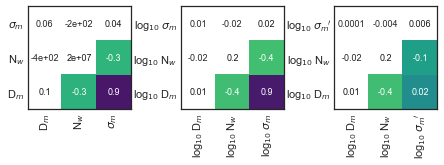

In [8]:
fig, [sp1, sp2, sp3] = plt.subplots(ncols=3)
supporting_routines.plotCorrelation(
    S_a[['Dm', 'Nw', 'Sm']].loc[['Dm', 'Nw', 'Sm']],
    fig,
    sp1,
    tickLabels=supporting_routines.niceKeys)
supporting_routines.plotCorrelation(
    S_a[['Dm_log10', 'Nw_log10',
         'Sm_log10']].loc[['Dm_log10', 'Nw_log10', 'Sm_log10']],
    fig,
    sp2,
    tickLabels=supporting_routines.niceKeys)

supporting_routines.plotCorrelation(
    S_a[['Dm_log10', 'Nw_log10',
         'Smprime_log10']].loc[['Dm_log10', 'Nw_log10', 'Smprime_log10']],
    fig,
    sp3,
    tickLabels=supporting_routines.niceKeys)

#
fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.2)
fig.savefig('x_corr.pdf')

## Measurement space
The measurement vector $\mathbf{y}$ consists of the radar reflectivity factor ($Z$) and the mean Doppler velocity ($V_d$) at 13.6 GHz and 35.5 GHz. Even though we use only 35.5 GHz in the following, we encourage the reader to experiment with different $\mathbf{y}$ combinations. For  $\mathbb{S}_y$, we assume that the uncertainties of  $Z$ and $V_d$ are 1 dB and 0.3 m s$^{-1}$, respectively, and that the errors are not correlated. Even though these error estimates are generally realistic, the values should be carefully evaluated for a real world application.

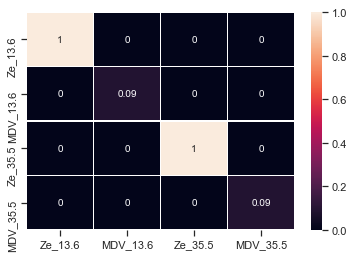

In [9]:
y_vars = ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]
y_noise = np.array([1, .3, 1, .3])
S_y = pn.DataFrame(
    np.diag(y_noise**2),
    index=y_vars,
    columns=y_vars,
)
sns.heatmap(S_y, annot=True, fmt='g', linewidths=.05)

## Retrieval
To prepare the retrieval, we set up PAMTRA2 properly and create dictionaries to store the results.

In [10]:
pam2Prepared = supporting_routines.preparePamtra(frequencies=[13.6e9, 35.5e9])
resultsOE = {}
failed = {}

Did not find information about relativePermittivityIce. This might cause trouble later.


/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos_th*cos_inc)/(sin_th*sin_inc))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:171: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.arccos((cos_inc-cos_th*cos_sca)/(sin_th*sin_sca))


In [11]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [12]:
reload(pamtra2)

<module 'pamtra2' from '/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/__init__.py'>

We run the retrieval for three configurations:

1. linear state variables
2. logarithmic state variables
3. logarithmic orthogonal state variables with $\sigma_m\!'$ instead of $\sigma_m$

In [13]:

x_names = dict([
        ('Linear', ['Dm', 'Nw', 'Sm']),
        ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Sm_log10']),
        ('log$_{10}$ with $\sigma_m\!$',
         ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
    ])



In this study, we use only a measurement configuration consisting of a radar reflectivity ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$). But the example is designed to work also with dual-frequency set ups and we encourage the reader to play around with these. 

The number in the last column is for a factor which is applied to the estimated measurement noise that allows to study the impact of measurement uncertainty on retrieval performance.

In [14]:
y_names = dict([
    #     name, [Y_variables],
    #     ('Z', ["Ze_13.6"]),
    ('ZW', ["Ze_13.6", "MDV_13.6"]),
    #     ('Zdual', ["Ze_13.6", "Ze_35.5"]),
    #     ('ZWdual', ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]),
])


# Example retrieval

to do: go step by step through retrieval design

In [15]:
tt = np.argmin(np.abs(rainDat_test['Dm'] - 1.202))
rainDat_test.isel(time=tt), tt

(<xarray.Dataset>
 Dimensions:        ()
 Coordinates:
     time           datetime64[ns] 2010-01-17T08:15:00
 Data variables:
     Dm             float64 1.202
     Z              float64 ...
     Nw             float64 5.823e+03
     Sm             float64 0.5611
     Smprime        float64 0.4368
     Nw_log10       float64 3.765
     Dm_log10       float64 0.07995
     Sm_log10       float64 -0.251
     Smprime_log10  float64 -0.3597, <xarray.DataArray 'Dm' ()>
 array(51))

In [16]:
for x_name, y_name, y_uncertainty_factor in (
    ('Linear', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$ with $\sigma_m\!$', 'ZW', 1),
    ('log$_{10}$ with $\sigma_m\!$', 'ZW', 2),
):
    for tt in [15, 20, 51]:
        x_vars = x_names[x_name]
        y_vars = y_names[y_name]

        #Additional required variables for the forward operator
        forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

        print('#' * 80)
        print(x_name, y_name, y_uncertainty_factor)
        print('#' * 80)



        x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]

        # simulate observation based on true state x_truth
        y_obs = supporting_routines.forwardPamtra(
            x_truth,
            pam2=pam2Prepared,
            y_vars=y_vars,
        )

        # create optimal estimation object
        oe = pyOE.optimalEstimation(
            x_vars,  # state variable names
            x_ap[x_vars],  # a priori
            S_a[x_vars].loc[x_vars],  # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs,  # observations
            S_y[y_vars].loc[y_vars] * y_uncertainty_factor**
            2,  # observation uncertainty
            supporting_routines.forwardPamtra,  # forward Operator
            forwardKwArgs=forwardKwArgs,  # additonal function arguments
        )

        # Store true profile in `oe` object. This is just for simplicity, it is not
        # used by the retrieval.
        oe.x_truth = x_truth

        # Do the retrieval with max. 10 iterations.
        converged = oe.doRetrieval(maxIter=10)

        if converged:

            # Test whethe rthe retrieval is moderately lienar around x_truth
            oe.linearityTest()

            # Show hdegrees of freedom per variable
            print(oe.dgf_x)

            # Show RMS normalized with prior
            print('RMS', np.sqrt(
                np.mean(((oe.x_truth - oe.x_op) / oe.x_a)**2)))

            # Apply chi2 tests for retrieval quality
            print(oe.chiSquareTest())

            oe.summarize(returnXarray=True)

################################################################################
Linear ZW 1
################################################################################
0.29 s, iteration 1, degrees of freedom: 1.71 of 3. convergence criteria NOT fullfilled  18.320
0.41 s, iteration 2, degrees of freedom: 1.60 of 3. convergence criteria NOT fullfilled  0.876
0.54 s, iteration 3, degrees of freedom: 1.60 of 3. convergence criteria fullfilled  0.062
0.66 s, iteration 4, degrees of freedom: 1.60 of 3.  Done.  0.010
Dm    0.289112
Nw    0.899222
Sm    0.410422
dtype: float64
RMS 0.5581428968295309
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation    13.192402
Y_Observation_vs_Prior      32.099609
Y_Optimal_vs_Prior          47.269002
X_Optimal_vs_Prior  

0.26 s, iteration 1, degrees of freedom: 1.62 of 3. convergence criteria NOT fullfilled  2.302
0.39 s, iteration 2, degrees of freedom: 1.55 of 3. convergence criteria fullfilled  0.055
0.51 s, iteration 3, degrees of freedom: 1.56 of 3.  Done.  0.002
Dm_log10         0.890553
Nw_log10         0.508456
Smprime_log10    0.160486
dtype: float64
RMS 0.6761656008414824
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation    13.664142
Y_Observation_vs_Prior      29.487842
Y_Optimal_vs_Prior          41.150229
X_Optimal_vs_Prior          12.565333
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: fl

# Run retrieval
The retrieval is run for all test profiles and all sets of state and measurement variables. 


For simplicity, we use a synthetic observations, i.e. we use PAMTRA2 to simulate an observation based on a known atmospheric state $\mathbf{x}_{truth}$. Even though $\mathbf{x}_{truth}$ is typically unknown in a real-world example, the use of synthetic observations is extremely helpful for assessing retrieval performance. 

The forward operator `forwardPamtra` is simply a Python function accepting $\mathbf{x}$ as an input. Additionally required function arguments are provided through the `forwardKwArgs` dictionary.

The `pyOptimalEstimation` library is object oriented, i.e., we need to create the `oe` object first before running the retrieval with `oe.doRetrieval`. 

If the retrieval converged, we use different measures to evaluate the retrieval quality:
1. Linearity test tests whether the problem is moderately linear following chapter 5.1 of Rodgers (2000). Values lower than 1 indicate that the effect of linearization is smaller than the measurement error and problem is nearly linear. In case $\mathbf{x}_{truth}$  is not available, error patterns of $\mathbb{S}$ can be used instead. 
2. The degrees of freedom for signal (dgf) for each individual variable. 
3. RMS: The root mean square error between the true profile $\mathbf{x}_{truth}$ and the retrieval result $\mathbf{x}_{optimal}$. We normalize with $\mathbf{x}_{a}$ to account for the different units. 
4. $\chi^2$ tests: We use four $\chi^2$ tests as described in chapter 12 of Rodgers (2000). We test whether
    1. the retrieved state $\mathbf{x}_{op}$ agrees with the prior $\mathbb{S}_a$
    2. the observation $\mathbf{y}_{truth}$ corresponding to $\mathbf{x}_{truth}$ agrees with the prior $\mathbb{S}_a$
    3. $\mathbf{y}_{truth}$  agrees with the measurement $\mathbf{y}_{obs}$ given the uncertainties $\mathbb{S}_y$ 
    4. the measurement $\mathbf{y}_{obs}$ agrees with the prior $\mathbb{S}_a$

In [36]:
for x_name, y_name, y_uncertainty_factor in (
    ('Linear', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$ with $\sigma_m\!$', 'ZW', 1),
    ('log$_{10}$ with $\sigma_m\!$', 'ZW', 2),
):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)] = []
    failed['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)] = []

    #Additional required variables for the forward operator
    forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

    print('#' * 80)
    print(x_name, y_name, y_uncertainty_factor)
    print('#' * 80)

#     for tt in [15, 20, 51]:
    for tt in range(rainDat_test[x_vars].time.shape[0]):

        x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]
        # simulate observation based on true state x_truth
        y_obs = supporting_routines.forwardPamtra(
            x_truth,
            pam2=pam2Prepared,
            y_vars=y_vars,
        )

        # create optimal estimation object
        oe = pyOE.optimalEstimation(
            x_vars,  # state variable names
            x_ap[x_vars],  # a priori
            S_a[x_vars].loc[x_vars],  # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs,  # observations
            S_y[y_vars].loc[y_vars] * y_uncertainty_factor**
            2,  # observation uncertainty
            supporting_routines.forwardPamtra,  # forward Operator
            forwardKwArgs=forwardKwArgs,  # additonal function arguments
        )

        # Store true profile in `oe` object. This is just for convenience, it is not
        # used by the retrieval.
        oe.x_truth = x_truth

        # Do the retrieval with max. 10 iterations.
        converged = oe.doRetrieval(maxIter=10)

        if converged:

            # Test whethe rthe retrieval is moderately lienar around x_truth
            print(oe.linearityTest())

            # Show hdegrees of freedom per variable
            print(oe.dgf_x)

            # Apply chi2 tests for retrieval quality
            print(oe.chiSquareTest())

            if x_name.startswith('log'):
                # Show RMS normalized with prior
                print('RMS log', np.sqrt(
                    np.mean(((10**oe.x_truth - 10**oe.x_op) / 10**oe.x_a)**2)))
                print('truth', 10**oe.x_truth)
                print('op', 10**unp.uarray(oe.x_op.values,
                                         oe.x_op_err.values))
            else:
                # Show RMS normalized with prior
                print('RMS', np.sqrt(
                    np.mean(((oe.x_truth - oe.x_op) / oe.x_a)**2)))
                print('truth', oe.x_truth)
                print('op', unp.uarray(oe.x_op.values,
                                         oe.x_op_err.values))
                
            #Store results in xarray DataArray
            summary = oe.summarize(returnXarray=True)
            resultsOE['%s_%s_%i' % (x_name, y_name,
                                    y_uncertainty_factor)].append(summary)
        else:
            failed['%s_%s_%i' % (x_name, y_name,
                                 y_uncertainty_factor)].append(tt)
    #Store results in xarray Dataset structure for later analysis.
    resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)] = xr.concat(
        resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)],
        dim='time')
    
# resultsOEs = xr.concat(resultsOE.values(), dim='configuration')
# resultsOEs['configuration'] = list(resultsOE.keys())
# resultsOEs[].to_dataframe().reset_index()

################################################################################
Linear ZW 1
################################################################################
0.26 s, iteration 1, degrees of freedom: 1.79 of 3. convergence criteria fullfilled  0.024
0.40 s, iteration 2, degrees of freedom: 1.79 of 3.  Done.  0.000
([1.3974989933866924, 0.008656394518333258, 8.286511669507937e-05], array(0.05597342), 5.991464547107983)
Dm    0.579834
Nw    0.602191
Sm    0.606119
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.169809
Y_Observation_vs_Prior      0.159493
Y_Optimal_vs_Prior          0.159706
X_Optimal_vs_Prior          0.172206
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Pr

0.28 s, iteration 1, degrees of freedom: 1.94 of 3. convergence criteria NOT fullfilled  3.266
0.41 s, iteration 2, degrees of freedom: 1.92 of 3. convergence criteria fullfilled  0.001
0.56 s, iteration 3, degrees of freedom: 1.92 of 3.  Done.  0.000
([7.125157366051628, 0.0037589021191569297, 0.00011883960989668721], array(0.01843694), 5.991464547107983)
Dm    0.383870
Nw    0.908975
Sm    0.629729
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.432651
Y_Observation_vs_Prior      0.213634
Y_Optimal_vs_Prior          0.209843
X_Optimal_vs_Prior          0.361499
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior     

/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Sm from nan to 0.508677 in iteration 1
0.24 s, iteration 1, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  14.216
0.42 s, iteration 2, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  195.981
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Sm from nan to 0.508677 in iteration 3
0.84 s, iteration 3, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  14.2

([22.957648760744128, 0.0002939785221494483, 3.7434001214384403e-07], array(0.0031871), 5.991464547107983)
Dm    0.275738
Nw    0.976084
Sm    0.564461
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation     True
Y_Observation_vs_Prior       True
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool, chi2test
Y_Optimal_vs_Observation    3.145476
Y_Observation_vs_Prior      5.973057
Y_Optimal_vs_Prior          6.667106
X_Optimal_vs_Prior          3.145325
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.12125429861135771
truth Dm       1.968510
Nw    1007.708401
Sm       0.919478
Name: 2010-01-17 15:20:00, dtype: float64
op [1.9953302619565605+/-0.18538424003743062
 1056.8455021757422+/-878.1

0.23 s, iteration 1, degrees of freedom: 1.74 of 3. convergence criteria NOT fullfilled  0.462
0.34 s, iteration 2, degrees of freedom: 1.75 of 3. convergence criteria fullfilled  0.002
0.46 s, iteration 3, degrees of freedom: 1.75 of 3.  Done.  0.000
([2.731835569672015, 0.0002843660598889193, 0.00015263279361092062], array(0.03883087), 5.991464547107983)
Dm    0.459838
Nw    0.704134
Sm    0.583896
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.977709
Y_Observation_vs_Prior      1.461659
Y_Optimal_vs_Prior          1.541478
X_Optimal_vs_Prior          1.011947
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior     

0.26 s, iteration 1, degrees of freedom: 1.90 of 3. convergence criteria NOT fullfilled  22.803
0.39 s, iteration 2, degrees of freedom: 1.87 of 3. convergence criteria fullfilled  0.064
0.51 s, iteration 3, degrees of freedom: 1.87 of 3.  Done.  0.001
([13.349881250252656, 0.00029278866562260195, 9.457908404729587e-05], array(0.01013108), 5.991464547107983)
Dm    0.309958
Nw    0.953582
Sm    0.606872
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.561861
Y_Observation_vs_Prior      1.916437
Y_Optimal_vs_Prior          1.996707
X_Optimal_vs_Prior          1.349727
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior   

0.24 s, iteration 1, degrees of freedom: 1.54 of 3. convergence criteria NOT fullfilled  7.062
0.36 s, iteration 2, degrees of freedom: 1.54 of 3. convergence criteria fullfilled  0.021
0.48 s, iteration 3, degrees of freedom: 1.53 of 3.  Done.  0.002
([0.15609489297495738, 0.020287096606990518, 5.277929697450853e-05], array(3.83001361), 5.991464547107983)
Dm    0.812146
Nw    0.278770
Sm    0.442771
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation     True
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool, chi2test
Y_Optimal_vs_Observation     5.503472
Y_Observation_vs_Prior       8.471777
Y_Optimal_vs_Prior          11.610571
X_Optimal_vs_Prior           5.808448
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Pr

0.25 s, iteration 1, degrees of freedom: 1.77 of 3. convergence criteria fullfilled  0.124
0.36 s, iteration 2, degrees of freedom: 1.77 of 3.  Done.  0.000
([1.1889911540642217, 0.012800929796765953, 7.998996453005588e-05], array(0.00350307), 5.991464547107983)
Dm    0.620232
Nw    0.559032
Sm    0.589416
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.376493
Y_Observation_vs_Prior      0.357730
Y_Optimal_vs_Prior          0.362359
X_Optimal_vs_Prior          0.381166
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.1481596908130377
truth Dm       1.235462

0.28 s, iteration 1, degrees of freedom: 1.93 of 3. convergence criteria NOT fullfilled  2.092
0.39 s, iteration 2, degrees of freedom: 1.92 of 3. convergence criteria fullfilled  0.000
0.50 s, iteration 3, degrees of freedom: 1.92 of 3.  Done.  0.000
([6.799079911893582, 0.010620911523524538, 8.58663657885979e-05], array(0.01363738), 5.991464547107983)
Dm    0.437830
Nw    0.875245
Sm    0.605058
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.748758
Y_Observation_vs_Prior      0.564410
Y_Optimal_vs_Prior          0.562448
X_Optimal_vs_Prior          0.722199
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior        

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Sm from nan to 0.508677 in iteration 9
1.18 s, iteration 9, degrees of freedom: 0.93 of 3. convergence criteria NOT fullfilled  4.385
0.23 s, iteration 1, degrees of freedom: 1.90 of 3. convergence criteria NOT fullfilled  4.763
0.34 s, iteration 2, degrees of freedom: 1.88 of 3. convergence criteria fullfilled  0.000
0.45 s, iteration 3, degrees of freedom: 1.88 of 3.  Done.  0.000
([8.733318789057122, 0.0002714265939142017, 0.00022215460269892382], array(0.01060593), 5.991464547107983)
Dm    0.337654
Nw    0.920103
Sm    0.617251
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation  

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 7
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 7
############################################################
reset due to nan: Sm from nan to 0.508677 in iteration 7
0.97 s, iteration 7, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  2.290
1.09 s, iteration 8, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  51.253
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Sm from nan to 0.508677 in iteration 9
1.22 s, iteration 9, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  2.290


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Sm from nan to 0.508677 in iteration 9
1.19 s, iteration 9, degrees of freedom: 0.86 of 3. convergence criteria NOT fullfilled  13.524
0.23 s, iteration 1, degrees of freedom: 1.67 of 3. convergence criteria NOT fullfilled  0.385
0.34 s, iteration 2, degrees of freedom: 1.68 of 3. convergence criteria fullfilled  0.002
0.46 s, iteration 3, degrees of freedom: 1.67 of 3.  Done.  0.000
([1.0968523804251975, 0.00040501542970408687, 0.0002518779285538347], array(0.00047563), 5.991464547107983)
Dm    0.556284
Nw    0.545931
Sm    0.572613
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation

0.23 s, iteration 1, degrees of freedom: 1.87 of 3. convergence criteria NOT fullfilled  0.263
0.34 s, iteration 2, degrees of freedom: 1.87 of 3. convergence criteria fullfilled  0.000
0.45 s, iteration 3, degrees of freedom: 1.87 of 3.  Done.  0.000
([3.633025979723015, 0.011067737240778863, 8.529082136835868e-05], array(0.3493997), 5.991464547107983)
Dm    0.501228
Nw    0.763882
Sm    0.605754
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.467282
Y_Observation_vs_Prior      0.430072
Y_Optimal_vs_Prior          0.429883
X_Optimal_vs_Prior          0.472340
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior        

0.27 s, iteration 1, degrees of freedom: 1.90 of 3. convergence criteria NOT fullfilled  1.269
0.39 s, iteration 2, degrees of freedom: 1.88 of 3. convergence criteria fullfilled  0.000
0.52 s, iteration 3, degrees of freedom: 1.88 of 3.  Done.  0.000
([6.007407688432087, 0.0007188833197454053, 0.00021686416887106342], array(0.2043464), 5.991464547107983)
Dm    0.371995
Nw    0.883595
Sm    0.629015
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.355344
Y_Observation_vs_Prior      0.349603
Y_Optimal_vs_Prior          0.347468
X_Optimal_vs_Prior          0.355509
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior      

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Sm from nan to 0.508677 in iteration 9
1.25 s, iteration 9, degrees of freedom: 0.94 of 3. convergence criteria NOT fullfilled  2.558
0.28 s, iteration 1, degrees of freedom: 1.95 of 3. convergence criteria NOT fullfilled  39.152
0.40 s, iteration 2, degrees of freedom: 1.93 of 3. convergence criteria NOT fullfilled  0.452
0.55 s, iteration 3, degrees of freedom: 1.93 of 3. convergence criteria fullfilled  0.003
0.67 s, iteration 4, degrees of freedom: 1.93 of 3.  Done.  0.000
([11.120811512550608, 0.0010842049933519934, 0.00016664997889730018], array(2.16752129), 5.991464547107983)
Dm    0.342429
Nw    0.954218
Sm    0.633459
dtype: float64
Warning. Singular Matrix with ra

0.28 s, iteration 1, degrees of freedom: 1.82 of 3. convergence criteria NOT fullfilled  0.241
0.40 s, iteration 2, degrees of freedom: 1.82 of 3. convergence criteria fullfilled  0.000
0.56 s, iteration 3, degrees of freedom: 1.82 of 3.  Done.  0.000
([2.287525674719543, 0.014739963376753401, 8.899904633317366e-05], array(2.62976749e-05), 5.991464547107983)
Dm    0.576327
Nw    0.658045
Sm    0.588335
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.552488
Y_Observation_vs_Prior      0.498663
Y_Optimal_vs_Prior          0.498046
X_Optimal_vs_Prior          0.557596
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior   

1.11 s, iteration 1, degrees of freedom: 1.90 of 3. convergence criteria NOT fullfilled  38.780
1.36 s, iteration 2, degrees of freedom: 1.87 of 3. convergence criteria NOT fullfilled  0.273
1.96 s, iteration 3, degrees of freedom: 1.87 of 3. convergence criteria fullfilled  0.003
2.17 s, iteration 4, degrees of freedom: 1.87 of 3.  Done.  0.000
([15.003597271248294, 0.00029409302238626373, 8.723442380053843e-05], array(0.00675043), 5.991464547107983)
Dm    0.304634
Nw    0.960830
Sm    0.606204
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.397750
Y_Observation_vs_Prior      1.997421
Y_Optimal_vs_Prior          2.081978
X_Optimal_vs_Prior          1.403109
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465


0.26 s, iteration 1, degrees of freedom: 1.95 of 3. convergence criteria NOT fullfilled  18.703
0.39 s, iteration 2, degrees of freedom: 1.94 of 3. convergence criteria fullfilled  0.074
0.53 s, iteration 3, degrees of freedom: 1.93 of 3.  Done.  0.001
([9.927468510686422, 0.0031943316754998465, 0.0001278500104157595], array(0.0006851), 5.991464547107983)
Dm    0.360163
Nw    0.944866
Sm    0.629780
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.215337
Y_Observation_vs_Prior      0.203185
Y_Optimal_vs_Prior          0.197838
X_Optimal_vs_Prior          0.458001
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior      

0.23 s, iteration 1, degrees of freedom: 1.79 of 3. convergence criteria fullfilled  0.000
0.34 s, iteration 2, degrees of freedom: 1.79 of 3.  Done.  0.000
([0.005269707554776849, 0.00011768103282471402, 0.00011164440517048099], array(0.00018673), 5.991464547107983)
Dm_log10    0.531156
Nw_log10    0.644697
Sm_log10    0.614836
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.067461
Y_Observation_vs_Prior      0.066345
Y_Optimal_vs_Prior          0.066044
X_Optimal_vs_Prior          0.067449
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.0558093695301

0.24 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.026
0.35 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.008528836147578635, 0.00010562619778517018, 4.5775405697018814e-05], array(0.00180604), 5.991464547107983)
Dm_log10    0.570399
Nw_log10    0.658298
Sm_log10    0.546500
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.368045
Y_Observation_vs_Prior      0.357604
Y_Optimal_vs_Prior          0.357429
X_Optimal_vs_Prior          0.344820
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.1033840245053

0.33 s, iteration 1, degrees of freedom: 1.63 of 3. convergence criteria NOT fullfilled  2.812
0.49 s, iteration 2, degrees of freedom: 1.55 of 3. convergence criteria fullfilled  0.066
0.66 s, iteration 3, degrees of freedom: 1.56 of 3.  Done.  0.002
([0.004070890274552715, 0.0011846785493253747, 5.3403240476611494e-05], array(0.27415318), 5.991464547107983)
Dm_log10    0.588780
Nw_log10    0.512664
Sm_log10    0.461781
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation    13.474608
Y_Observation_vs_Prior      28.850678
Y_Optimal_vs_Prior          39.766220
X_Optimal_vs_Prior          12.587839
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.9

0.27 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.000
0.39 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.005984834316033556, 0.00010682612828061173, 8.095414057057235e-05], array(0.00016713), 5.991464547107983)
Dm_log10    0.561725
Nw_log10    0.655258
Sm_log10    0.564175
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.322777
Y_Observation_vs_Prior      1.328046
Y_Optimal_vs_Prior          1.330027
X_Optimal_vs_Prior          1.322482
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.42705601937713

0.27 s, iteration 1, degrees of freedom: 1.72 of 3. convergence criteria NOT fullfilled  0.801
0.39 s, iteration 2, degrees of freedom: 1.72 of 3. convergence criteria fullfilled  0.000
0.53 s, iteration 3, degrees of freedom: 1.72 of 3.  Done.  0.000
([0.007420024327643743, 5.924990104960502e-05, 2.933598313102867e-07], array(0.1752877), 5.991464547107983)
Dm_log10    0.671416
Nw_log10    0.662889
Sm_log10    0.380799
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation     True
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool, chi2test
Y_Optimal_vs_Observation    5.631481
Y_Observation_vs_Prior      6.727220
Y_Optimal_vs_Prior          7.131340
X_Optimal_vs_Prior          5.633963
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465


0.22 s, iteration 1, degrees of freedom: 1.77 of 3. convergence criteria fullfilled  0.016
0.32 s, iteration 2, degrees of freedom: 1.77 of 3.  Done.  0.000
([0.007918493774216636, 0.00010165497609271948, 5.314320108624409e-05], array(0.20857409), 5.991464547107983)
Dm_log10    0.588881
Nw_log10    0.666423
Sm_log10    0.517992
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.462635
Y_Observation_vs_Prior      2.496545
Y_Optimal_vs_Prior          2.504101
X_Optimal_vs_Prior          2.465810
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.25433136303982

0.27 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.006
0.38 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.003213958590545851, 0.0001039243867246795, 7.115921453227722e-05], array(9.04485023e-07), 5.991464547107983)
Dm_log10    0.509794
Nw_log10    0.619601
Sm_log10    0.653747
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.604957
Y_Observation_vs_Prior      0.614970
Y_Optimal_vs_Prior          0.619334
X_Optimal_vs_Prior          0.604579
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.03810733590

0.28 s, iteration 1, degrees of freedom: 1.75 of 3. convergence criteria fullfilled  0.065
0.41 s, iteration 2, degrees of freedom: 1.75 of 3.  Done.  0.000
([0.0016478004977528433, 8.371636350356626e-05, 5.100626605394046e-05], array(0.00019355), 5.991464547107983)
Dm_log10    0.504573
Nw_log10    0.582331
Sm_log10    0.665600
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.686776
Y_Observation_vs_Prior      2.091520
Y_Optimal_vs_Prior          2.218191
X_Optimal_vs_Prior          1.709636
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.07673980746819

0.23 s, iteration 1, degrees of freedom: 1.76 of 3. convergence criteria fullfilled  0.030
0.35 s, iteration 2, degrees of freedom: 1.76 of 3.  Done.  0.000
([0.0026932136741056583, 8.26992711470635e-05, 4.580869142491315e-05], array(0.00013512), 5.991464547107983)
Dm_log10    0.532558
Nw_log10    0.609637
Sm_log10    0.618058
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.227187
Y_Observation_vs_Prior      1.139153
Y_Optimal_vs_Prior          1.130503
X_Optimal_vs_Prior          1.194473
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.156096294543525

0.24 s, iteration 1, degrees of freedom: 1.73 of 3. convergence criteria NOT fullfilled  0.497
0.36 s, iteration 2, degrees of freedom: 1.73 of 3. convergence criteria fullfilled  0.000
0.48 s, iteration 3, degrees of freedom: 1.73 of 3.  Done.  0.000
([0.008236290488059673, 6.740803204094122e-05, 3.6236800458885645e-07], array(0.00530579), 5.991464547107983)
Dm_log10    0.643859
Nw_log10    0.658705
Sm_log10    0.423890
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.925276
Y_Observation_vs_Prior      2.438678
Y_Optimal_vs_Prior          2.586831
X_Optimal_vs_Prior          1.924531
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_

0.25 s, iteration 1, degrees of freedom: 1.79 of 3. convergence criteria fullfilled  0.002
0.37 s, iteration 2, degrees of freedom: 1.79 of 3.  Done.  0.000
([0.006969287055225084, 0.00011801980198661218, 9.05186461270294e-05], array(4.27240475e-06), 5.991464547107983)
Dm_log10    0.545754
Nw_log10    0.652986
Sm_log10    0.588754
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.244778
Y_Observation_vs_Prior      0.243797
Y_Optimal_vs_Prior          0.244635
X_Optimal_vs_Prior          0.240593
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.05993281735

0.24 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.003
0.35 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.00707138115639353, 0.00010806404600348227, 7.236722465654483e-05], array(0.00260263), 5.991464547107983)
Dm_log10    0.569533
Nw_log10    0.660490
Sm_log10    0.550071
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.966184
Y_Observation_vs_Prior      0.972460
Y_Optimal_vs_Prior          0.973494
X_Optimal_vs_Prior          0.967429
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.760221320851457

0.26 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.001
0.38 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.0043562050502092015, 0.00010637225579218647, 8.699510314613779e-05], array(0.0022466), 5.991464547107983)
Dm_log10    0.533198
Nw_log10    0.637824
Sm_log10    0.613031
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.198818
Y_Observation_vs_Prior      0.188577
Y_Optimal_vs_Prior          0.188295
X_Optimal_vs_Prior          0.195124
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.23485320735115

0.23 s, iteration 1, degrees of freedom: 1.75 of 3. convergence criteria NOT fullfilled  0.284
0.34 s, iteration 2, degrees of freedom: 1.74 of 3. convergence criteria fullfilled  0.000
0.46 s, iteration 3, degrees of freedom: 1.74 of 3.  Done.  0.000
([0.00897825026152038, 7.811762279468872e-05, 2.410491229331694e-06], array(0.00057186), 5.991464547107983)
Dm_log10    0.615450
Nw_log10    0.656201
Sm_log10    0.469851
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.286419
Y_Observation_vs_Prior      1.471758
Y_Optimal_vs_Prior          1.497898
X_Optimal_vs_Prior          1.285191
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Op

0.21 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.002
0.32 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.009158416125779964, 0.0005877200966522445, 0.00016274027463877969], array(0.00038239), 5.991464547107983)
Dm_log10         0.949704
Nw_log10         0.649275
Smprime_log10    0.184353
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.416505
Y_Observation_vs_Prior      0.418131
Y_Optimal_vs_Prior          0.418055
X_Optimal_vs_Prior          0.415434
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.21 s, iteration 1, degrees of freedom: 1.75 of 3. convergence criteria fullfilled  0.113
0.33 s, iteration 2, degrees of freedom: 1.75 of 3.  Done.  0.000
([0.011779567005679597, 0.00018545197381466475, 0.00016376673330554422], array(0.00080607), 5.991464547107983)
Dm_log10         0.955417
Nw_log10         0.665837
Smprime_log10    0.128468
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.546265
Y_Observation_vs_Prior      2.766019
Y_Optimal_vs_Prior          2.834254
X_Optimal_vs_Prior          2.552066
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

0.25 s, iteration 1, degrees of freedom: 1.72 of 3. convergence criteria fullfilled  0.179
0.38 s, iteration 2, degrees of freedom: 1.71 of 3.  Done.  0.000
([0.0009484215824641617, 0.0003224451649154775, 0.00020344428176514024], array(3.45256052e-05), 5.991464547107983)
Dm_log10         0.936487
Nw_log10         0.552173
Smprime_log10    0.224873
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.566424
Y_Observation_vs_Prior      3.824510
Y_Optimal_vs_Prior          4.272632
X_Optimal_vs_Prior          2.668584
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 

0.21 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.003
0.31 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.0044861043361225615, 0.0010916516814268049, 3.9124675606165325e-05], array(0.00127121), 5.991464547107983)
Dm_log10         0.947516
Nw_log10         0.624103
Smprime_log10    0.208961
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.187762
Y_Observation_vs_Prior      0.190292
Y_Optimal_vs_Prior          0.192289
X_Optimal_vs_Prior          0.186762
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

0.25 s, iteration 1, degrees of freedom: 1.74 of 3. convergence criteria NOT fullfilled  0.272
0.37 s, iteration 2, degrees of freedom: 1.73 of 3. convergence criteria fullfilled  0.000
0.49 s, iteration 3, degrees of freedom: 1.73 of 3.  Done.  0.000
([0.011258120752734855, 0.00014130012728796965, 0.00011972334487098217], array(0.00225625), 5.991464547107983)
Dm_log10         0.954076
Nw_log10         0.661789
Smprime_log10    0.117323
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.276780
Y_Observation_vs_Prior      2.726228
Y_Optimal_vs_Prior          2.866077
X_Optimal_vs_Prior          2.276709
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior     

0.25 s, iteration 1, degrees of freedom: 1.72 of 3. convergence criteria NOT fullfilled  0.474
0.36 s, iteration 2, degrees of freedom: 1.72 of 3. convergence criteria fullfilled  0.000
0.50 s, iteration 3, degrees of freedom: 1.72 of 3.  Done.  0.000
([0.010259177677620175, 0.0001178947600211626, 8.763808202504799e-05], array(0.01742535), 5.991464547107983)
Dm_log10         0.953438
Nw_log10         0.658936
Smprime_log10    0.107653
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.881134
Y_Observation_vs_Prior      3.627590
Y_Optimal_vs_Prior          3.878060
X_Optimal_vs_Prior          2.880367
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior       

0.24 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.000
0.36 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.006580444127876635, 0.0008385691816974125, 7.253808792237373e-05], array(0.0010946), 5.991464547107983)
Dm_log10         0.950548
Nw_log10         0.642146
Smprime_log10    0.190900
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.076912
Y_Observation_vs_Prior      0.075921
Y_Optimal_vs_Prior          0.075765
X_Optimal_vs_Prior          0.076900
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.2

0.24 s, iteration 1, degrees of freedom: 1.76 of 3. convergence criteria fullfilled  0.047
0.34 s, iteration 2, degrees of freedom: 1.76 of 3.  Done.  0.000
([0.0023087310947222956, 0.0009285062126190504, 0.00010151937061489533], array(2.65636689e-07), 5.991464547107983)
Dm_log10         0.942784
Nw_log10         0.588867
Smprime_log10    0.224836
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.013804
Y_Observation_vs_Prior      1.200489
Y_Optimal_vs_Prior          1.263034
X_Optimal_vs_Prior          1.005564
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 

0.25 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.000
0.38 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.007455520934407895, 0.0007225961943745785, 9.733922056940146e-05], array(1.54919185e-05), 5.991464547107983)
Dm_log10         0.951471
Nw_log10         0.647401
Smprime_log10    0.183809
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.125316
Y_Observation_vs_Prior      0.125176
Y_Optimal_vs_Prior          0.125141
X_Optimal_vs_Prior          0.125365
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS lo

0.27 s, iteration 1, degrees of freedom: 1.66 of 3. convergence criteria NOT fullfilled  0.629
0.40 s, iteration 2, degrees of freedom: 1.64 of 3. convergence criteria fullfilled  0.005
0.53 s, iteration 3, degrees of freedom: 1.64 of 3.  Done.  0.000
([0.000383831301817308, 5.226059788532645e-05, 2.4890099947968125e-05], array(0.05575783), 5.991464547107983)
Dm_log10         0.914478
Nw_log10         0.511782
Smprime_log10    0.217455
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation     7.870329
Y_Observation_vs_Prior      15.255963
Y_Optimal_vs_Prior          19.120272
X_Optimal_vs_Prior           7.700795
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Pri

0.24 s, iteration 1, degrees of freedom: 1.75 of 3. convergence criteria NOT fullfilled  0.226
0.35 s, iteration 2, degrees of freedom: 1.74 of 3. convergence criteria fullfilled  0.000
0.46 s, iteration 3, degrees of freedom: 1.74 of 3.  Done.  0.000
([0.01138433534803441, 0.00019138176243903225, 0.000123249716025358], array(4.27847836e-07), 5.991464547107983)
Dm_log10         0.949973
Nw_log10         0.649631
Smprime_log10    0.140108
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.208505
Y_Observation_vs_Prior      2.327612
Y_Optimal_vs_Prior          2.318051
X_Optimal_vs_Prior          2.208095
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior    

0.25 s, iteration 1, degrees of freedom: 1.79 of 3. convergence criteria fullfilled  0.003
0.36 s, iteration 2, degrees of freedom: 1.79 of 3.  Done.  0.000
([0.004669685953123593, 0.0011999495760242319, 4.10670284369657e-05], array(0.22906295), 5.991464547107983)
Dm_log10         0.945373
Nw_log10         0.624193
Smprime_log10    0.218633
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.650122
Y_Observation_vs_Prior      0.645051
Y_Optimal_vs_Prior          0.643749
X_Optimal_vs_Prior          0.647016
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.2

0.23 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.044
0.33 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.010666433920336648, 0.0004612337728527178, 0.00020043174259757536], array(0.00225183), 5.991464547107983)
Dm_log10         0.945356
Nw_log10         0.640628
Smprime_log10    0.191276
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation    6.201843
Y_Observation_vs_Prior      6.153664
Y_Optimal_vs_Prior          6.132109
X_Optimal_vs_Prior          6.169721
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS l

0.23 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.000
0.34 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.008000296725141316, 0.0006634412176653332, 0.00011529142527229243], array(0.00583841), 5.991464547107983)
Dm_log10         0.951622
Nw_log10         0.649656
Smprime_log10    0.181045
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.091491
Y_Observation_vs_Prior      0.091704
Y_Optimal_vs_Prior          0.091752
X_Optimal_vs_Prior          0.091548
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.23 s, iteration 1, degrees of freedom: 1.43 of 3. convergence criteria fullfilled  0.001
0.36 s, iteration 2, degrees of freedom: 1.43 of 3.  Done.  0.000
([0.0052703057818878594, 0.00038746181999400534, 0.00011049886369113543], array(0.00034261), 5.991464547107983)
Dm_log10         0.908813
Nw_log10         0.408456
Smprime_log10    0.110944
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.132007
Y_Observation_vs_Prior      0.136010
Y_Optimal_vs_Prior          0.137576
X_Optimal_vs_Prior          0.131917
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log

0.25 s, iteration 1, degrees of freedom: 1.34 of 3. convergence criteria fullfilled  0.137
0.37 s, iteration 2, degrees of freedom: 1.33 of 3.  Done.  0.000
([0.0038051410077018398, 0.0001683318354383654, 0.0001433228229751615], array(0.01920618), 5.991464547107983)
Dm_log10         0.885976
Nw_log10         0.377219
Smprime_log10    0.069181
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    3.705685
Y_Observation_vs_Prior      3.995836
Y_Optimal_vs_Prior          4.063109
X_Optimal_vs_Prior          3.698479
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.24 s, iteration 1, degrees of freedom: 1.42 of 3. convergence criteria fullfilled  0.004
0.36 s, iteration 2, degrees of freedom: 1.42 of 3.  Done.  0.000
([0.00545249074378336, 0.00040987461752876913, 0.00014694660778213767], array(0.00124335), 5.991464547107983)
Dm_log10         0.906813
Nw_log10         0.407628
Smprime_log10    0.100773
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.476514
Y_Observation_vs_Prior      0.498212
Y_Optimal_vs_Prior          0.514814
X_Optimal_vs_Prior          0.476390
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 1

0.27 s, iteration 1, degrees of freedom: 1.37 of 3. convergence criteria fullfilled  0.041
0.41 s, iteration 2, degrees of freedom: 1.37 of 3.  Done.  0.000
([0.005008230182672615, 0.00028384108839147037, 0.00021541899352974458], array(0.00525945), 5.991464547107983)
Dm_log10         0.895513
Nw_log10         0.394844
Smprime_log10    0.079866
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.193654
Y_Observation_vs_Prior      1.395496
Y_Optimal_vs_Prior          1.540598
X_Optimal_vs_Prior          1.200828
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

0.24 s, iteration 1, degrees of freedom: 1.44 of 3. convergence criteria fullfilled  0.000
0.36 s, iteration 2, degrees of freedom: 1.44 of 3.  Done.  0.000
([0.00466564517976215, 0.00029059364457405777, 6.677348447479866e-05], array(0.00143741), 5.991464547107983)
Dm_log10         0.910528
Nw_log10         0.406574
Smprime_log10    0.126899
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.252827
Y_Observation_vs_Prior      0.252669
Y_Optimal_vs_Prior          0.252395
X_Optimal_vs_Prior          0.252843
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.

0.27 s, iteration 1, degrees of freedom: 1.41 of 3. convergence criteria fullfilled  0.006
0.39 s, iteration 2, degrees of freedom: 1.41 of 3.  Done.  0.000
([0.0022016052521752535, 0.00010834919180181388, 8.559128314736236e-05], array(0.00087928), 5.991464547107983)
Dm_log10         0.914944
Nw_log10         0.370148
Smprime_log10    0.121763
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.683423
Y_Observation_vs_Prior      2.533465
Y_Optimal_vs_Prior          2.392874
X_Optimal_vs_Prior          2.678123
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

0.22 s, iteration 1, degrees of freedom: 1.42 of 3. convergence criteria fullfilled  0.002
0.33 s, iteration 2, degrees of freedom: 1.42 of 3.  Done.  0.000
([0.005246390661574361, 0.0003900743491202024, 0.0001214223717477896], array(0.0035993), 5.991464547107983)
Dm_log10         0.909118
Nw_log10         0.408440
Smprime_log10    0.105242
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.485998
Y_Observation_vs_Prior      0.495520
Y_Optimal_vs_Prior          0.504133
X_Optimal_vs_Prior          0.485718
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.3

0.25 s, iteration 1, degrees of freedom: 1.45 of 3. convergence criteria fullfilled  0.000
0.37 s, iteration 2, degrees of freedom: 1.45 of 3.  Done.  0.000
([0.00400547528982791, 0.00019170333813694953, 4.9828001212674124e-05], array(0.09128283), 5.991464547107983)
Dm_log10         0.912206
Nw_log10         0.402000
Smprime_log10    0.130975
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.078580
Y_Observation_vs_Prior      0.078284
Y_Optimal_vs_Prior          0.077960
X_Optimal_vs_Prior          0.078566
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.24 s, iteration 1, degrees of freedom: 1.45 of 3. convergence criteria fullfilled  0.000
0.37 s, iteration 2, degrees of freedom: 1.45 of 3.  Done.  0.000
([0.0048189299893522785, 0.0003126881566889284, 6.865938380070478e-05], array(0.07939113), 5.991464547107983)
Dm_log10         0.909371
Nw_log10         0.407136
Smprime_log10    0.130010
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.844424
Y_Observation_vs_Prior      0.843855
Y_Optimal_vs_Prior          0.842375
X_Optimal_vs_Prior          0.844491
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.23 s, iteration 1, degrees of freedom: 1.39 of 3. convergence criteria fullfilled  0.011
0.33 s, iteration 2, degrees of freedom: 1.39 of 3.  Done.  0.000
([0.0014061471568497072, 0.00023206642120022155, 0.00016557104199826074], array(0.02605136), 5.991464547107983)
Dm_log10         0.908046
Nw_log10         0.346499
Smprime_log10    0.131059
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.467767
Y_Observation_vs_Prior      1.501568
Y_Optimal_vs_Prior          1.563666
X_Optimal_vs_Prior          1.469435
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log

0.25 s, iteration 1, degrees of freedom: 1.30 of 3. convergence criteria fullfilled  0.050
0.37 s, iteration 2, degrees of freedom: 1.30 of 3.  Done.  0.000
([0.0007540313985894556, 0.0005779494426834655, 0.00028703724194901326], array(4.25191289e-05), 5.991464547107983)
Dm_log10         0.881582
Nw_log10         0.302830
Smprime_log10    0.112883
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation     True
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool, chi2test
Y_Optimal_vs_Observation    5.042394
Y_Observation_vs_Prior      6.584998
Y_Optimal_vs_Prior          8.786725
X_Optimal_vs_Prior          5.186654
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)


0.25 s, iteration 1, degrees of freedom: 1.40 of 3. convergence criteria fullfilled  0.006
0.39 s, iteration 2, degrees of freedom: 1.40 of 3.  Done.  0.000
([0.0017545529947328186, 0.00016416020626021336, 0.00011065145374544163], array(1.6878547e-06), 5.991464547107983)
Dm_log10         0.910534
Nw_log10         0.359056
Smprime_log10    0.133610
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.951054
Y_Observation_vs_Prior      0.955542
Y_Optimal_vs_Prior          0.980603
X_Optimal_vs_Prior          0.950481
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 

0.23 s, iteration 1, degrees of freedom: 1.41 of 3. convergence criteria fullfilled  0.006
0.33 s, iteration 2, degrees of freedom: 1.41 of 3.  Done.  0.000
([0.005609690511902649, 0.0004113641556917341, 0.00016468609482646237], array(6.69606698e-05), 5.991464547107983)
Dm_log10         0.904217
Nw_log10         0.405933
Smprime_log10    0.099284
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.398786
Y_Observation_vs_Prior      0.430484
Y_Optimal_vs_Prior          0.444393
X_Optimal_vs_Prior          0.398976
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS l

0.36 s, iteration 1, degrees of freedom: 1.41 of 3. convergence criteria fullfilled  0.008
0.57 s, iteration 2, degrees of freedom: 1.41 of 3.  Done.  0.000
([0.0055622089522156005, 0.0004046119340486525, 0.0001738147365466073], array(0.00749196), 5.991464547107983)
Dm_log10         0.903878
Nw_log10         0.405457
Smprime_log10    0.096006
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.506874
Y_Observation_vs_Prior      0.551177
Y_Optimal_vs_Prior          0.579283
X_Optimal_vs_Prior          0.507389
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

# Analyze results

In the following, we evaluate retrieval quality using various methods. First, we make a panda DataFrame with the quantities we are interested in.

In [37]:
resultsOEMerged = {}
for key in resultsOE.keys():
    if key.startswith('Linear_'):
        resultsOEMerged[key] = resultsOE[key]
    elif key.startswith('log$_{10}$_'):
        assert resultsOE[key].x_vars[0] == 'Dm_log10'
        assert resultsOE[key].x_vars[2] == 'Sm_log10'
        
        linState = {}
        linState['x_truth'] = 10**resultsOE[key].x_truth
        x_op = 10**unp.uarray(resultsOE[key].x_op.values,
                                     resultsOE[key].x_op_err.values)
        x_a = 10**unp.uarray(resultsOE[key].x_a.values,
                                     resultsOE[key].x_a_err.values)

        linState['x_op_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_op)
        linState['x_op'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_op)
        linState['x_a_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_a)
        linState['x_a'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_a)
        linState['dgf_x'] = resultsOE[key]['dgf_x']

        linState = xr.Dataset(linState)
#         linState = linState.rename({'variable':'x_vars'})
        linState['x_vars'] = ['Dm', 'Nw', 'Sm']
        resultsOEMerged[key] = xr.merge((resultsOE[key],linState))

    elif key.startswith('log$_{10}$ with $\\sigma_m\\!$_'):
        assert resultsOE[key].x_vars[0] == 'Dm_log10'
        assert resultsOE[key].x_vars[2] == 'Smprime_log10'
        
        linState = {}
        linState['x_truth'] = 10**resultsOE[key].x_truth
        linState['x_truth'][:, 2].values = linState[
            'x_truth'][:, 2].values * linState['x_truth'][:, 0].values**1.36
        x_op = 10**unp.uarray(resultsOE[key].x_op.values,
                                     resultsOE[key].x_op_err.values)
        x_op[:, 2] = x_op[:, 2] * x_op[:, 0]**1.36
        x_a = 10**unp.uarray(resultsOE[key].x_a.values,
                                     resultsOE[key].x_a_err.values)
        x_a[:, 2] = x_a[:, 2] * x_a[:, 0]**1.36
        
        linState['x_op_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_op)
        linState['x_op'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_op)
        linState['x_a_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_a)
        linState['x_a'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_a)

        linState['dgf_x'] =  resultsOE[key]['dgf_x']


        linState = xr.Dataset(linState)
#         linState = linState.rename({'variable':'x_vars'})

        linState['x_vars'] = ['Dm', 'Nw', 'Sm']
        resultsOEMerged[key] = xr.merge((resultsOE[key],linState))

    else:
        raise ValueError

In [38]:

df = []

for xx, (x_name, y_name, y_uncertainty_factor) in enumerate((
    ('Linear', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$ with $\\sigma_m\\!$', 'ZW', 1),
    ('log$_{10}$ with $\\sigma_m\\!$', 'ZW', 2),
)):

    x_vars = ['Nw', 'Dm', 'Sm']
    y_vars = y_names[y_name]

    y_name2 = '%s' % (y_name)
    x_name2 = '%s_%i' % (x_name, y_uncertainty_factor)

    for xx, x_var in enumerate(x_vars):
        thisOe = resultsOEMerged['%s_%s_%i' % (x_name, y_name,
                                         y_uncertainty_factor)].sel(
                                             x_vars=x_var)
        for ii in range(len(thisOe.time)):

            dgf = thisOe.dgf_x.values[ii]
            re = (thisOe.x_op_err.values[ii] / thisOe.x_op.values[ii])
            ri = (thisOe.x_op_err.values[ii] / thisOe.x_a_err.values[ii])

            df.append((dgf, re, ri, np.nan, np.nan, x_var, x_var.split('_')[0].replace(
                           'prime', ''), y_name2, x_name2))
    for ii in range(len(thisOe.time)):
        cv = thisOe.chi2value[ii]
        cc = thisOe.chi2critical[ii]
        nn = thisOe.trueLinearityChi2.values[ii] < thisOe.trueLinearityChi2Critical.values[ii]
        print(thisOe.trueLinearityChi2.values[ii] ,thisOe.trueLinearityChi2Critical.values[ii])
        dgf_tot = thisOe.dgf.values[ii]
        df.append((dgf_tot, np.nan, np.nan, (cv <= cc).all('chi2test').values,
                       nn, 'total', 'total', y_name2,
                    x_name2))

df = pn.DataFrame(
    df,
    columns=[
        'degrees of freedom', 'relative error', 'relative improvement',
        'chi2Test', 'nonlinearTest', 'x_var', 'x_var_simple', 'y_name',
        'x_name'
    ])

0.055973416591325514 5.991464547107983
0.272058572444197 5.991464547107983
0.003440629487748483 5.991464547107983
0.007158463575713262 5.991464547107983
0.030426745085682872 5.991464547107983
0.0002727426372213272 5.991464547107983
5.9527480433572436e-05 5.991464547107983
0.01843693623265409 5.991464547107983
0.6378367066458349 5.991464547107983
0.17483875246955877 5.991464547107983
0.7229419578063906 5.991464547107983
0.052323260335925124 5.991464547107983
0.003187100427049782 5.991464547107983
88.1935865855463 5.991464547107983
0.277361433910851 5.991464547107983
0.18540908748458965 5.991464547107983
0.07172417301151258 5.991464547107983
0.43718384433294294 5.991464547107983
165.84085454616488 5.991464547107983
0.0388308706934525 5.991464547107983
0.006176553515357738 5.991464547107983
0.0015247206574556138 5.991464547107983
0.006081837475726943 5.991464547107983
0.00023307163192886504 5.991464547107983
0.22926593652246566 5.991464547107983
0.006559087075990825 5.991464547107983
0.01

1.4601195642453472e-05 5.991464547107983
0.1008612571592137 5.991464547107983
0.058222106399976575 5.991464547107983
0.05575782571944549 5.991464547107983
0.045176318576064134 5.991464547107983
0.0037414800147240624 5.991464547107983
2.405377595180656e-05 5.991464547107983
0.10061295071483092 5.991464547107983
0.0002581197073541052 5.991464547107983
0.007852863487770952 5.991464547107983
4.2784783629144603e-07 5.991464547107983
0.0023898371251173424 5.991464547107983
1.8254165505204646e-05 5.991464547107983
0.06225089536175127 5.991464547107983
0.026901480208824158 5.991464547107983
4.834545625902811e-06 5.991464547107983
0.06013995500340384 5.991464547107983
0.22906295337581992 5.991464547107983
0.005207630828222551 5.991464547107983
0.0018532774360532115 5.991464547107983
0.06783951802572384 5.991464547107983
1.7592338084810632e-05 5.991464547107983
1.0354761071894725e-05 5.991464547107983
3.2388529701648994e-05 5.991464547107983
0.0022518339286154883 5.991464547107983
8.650914390909

## Retrieval error distribution

The fact that we know $\mathbf{x}_{truth}$ allows us to investigate the distributions of the retrieval errors. When defined with

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathbb{S}_y)}}
   \end{equation}

with  $\mathbb{S}$ is the retrieval uncertainty of $\mathbf{x}_{truth}$, it should follow a normal distribution with mean 0 and standard deviation 1. 



Linear ZW Dm -0.033949451976162726 1.1325572225703247
Linear ZW Nw -0.22783930147810716 0.7730941639813532
Linear ZW Sm -0.03106477258302218 0.6199265924563853
log$_{10}$ ZW Dm_log10 -0.05422649766829923 1.030634535758802
log$_{10}$ ZW Nw_log10 0.0640992472825088 0.9729109580412436
log$_{10}$ ZW Sm_log10 0.08313113375210371 0.7142223788601647
log$_{10}$ with $\sigma_m\!$ ZW Dm_log10 -0.05545255878702741 1.0254812892527936
log$_{10}$ with $\sigma_m\!$ ZW Nw_log10 0.0658998765191465 0.9711886879599965
log$_{10}$ with $\sigma_m\!$ ZW Smprime_log10 0.15169484731442728 1.0915417217987842


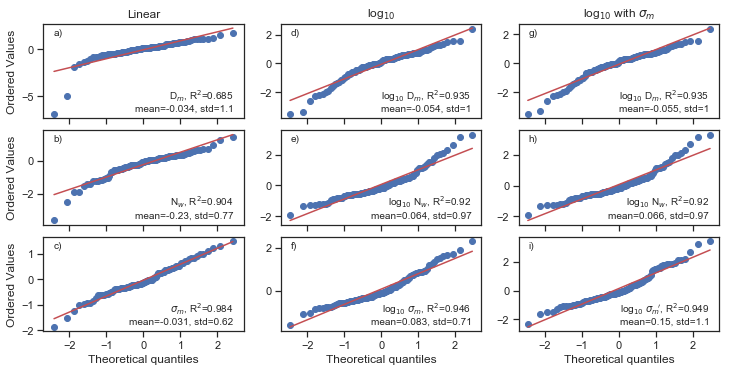

In [39]:
fig, sps = plt.subplots(
    figsize=(10, 5), nrows=len(x_vars), ncols=3, sharex=True)
sps = sps.reshape((len(x_vars), 3))

xx = 0
jj = 0

for xx, (x_name, y_name, y_uncertainty_factor) in enumerate((
    ('Linear', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$ with $\\sigma_m\\!$', 'ZW', 1),
#     ('Logarithmic orthogonal', 'ZW', 2),
)):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    for kk in range(3):

        x_var = x_vars[kk]
        thisOe = resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)].sel(x_vars=x_var)
        x_err = ((
            thisOe['x_op'] - thisOe['x_truth']) / thisOe['x_op_err'])

        x_mean = x_err.mean().values
        x_std = x_err.std().values

        print(x_name, y_name, x_var, x_mean, x_std)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            x_err, dist="norm", plot=sps[kk, xx], fit=True, rvalue=False)
        if kk > 0: sps[kk, xx].set_title('')
        else: sps[kk, xx].set_title(x_name)
        sps[kk, xx].text(
            0.95,
            0.05,
            '%s, R$^2$=%.3g\nmean=%.2g, std=%.2g' %
            (supporting_routines.niceKeys[x_var], r**2, x_mean, x_std),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=sps[kk, xx].transAxes)
        sps[kk, xx].text(
            0.05,
            0.95,
            '%s)' % (abc[jj]),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, xx].transAxes)

        if kk < 2:
            sps[kk, xx].set_xlabel("")
        if xx > 0:
            sps[kk, xx].set_ylabel("")

        jj += 1

fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.)
# fig.savefig('qq_xerr_lin_log_%s.pdf'%(version))

The comparison of the retrieval with linear (first column) and logarithmic (second column) errors reveals that the error distributions are in much better agreement with a Gaussian distribution. For all three state variables, $R^2$ values and are increased and standard deviations are closer to 1. For the retrieval version with orthogonal state variables (third column), the use of $\sigma_m\!'$ instead of $\sigma_m$ enhances $R^2$ and standard deviation even further. 

## relative errors

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathbb{S}_y)}}
   \end{equation}



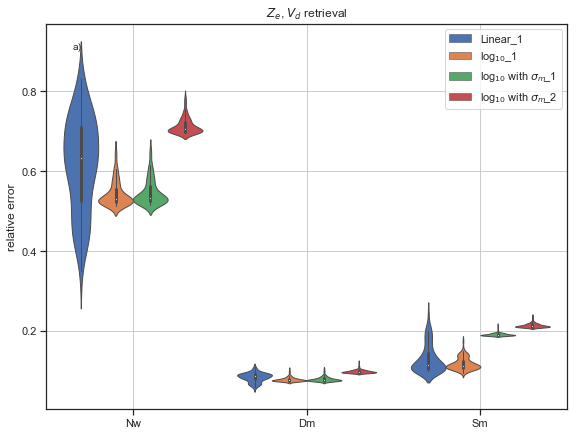

In [40]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):
    sns.violinplot(
        x='x_var_simple',
        y='relative error',
        hue='x_name',
        data=df[['x_var_simple','relative error','x_name']].where(df.y_name == y_name).dropna(0, how='any'),
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

## dgf

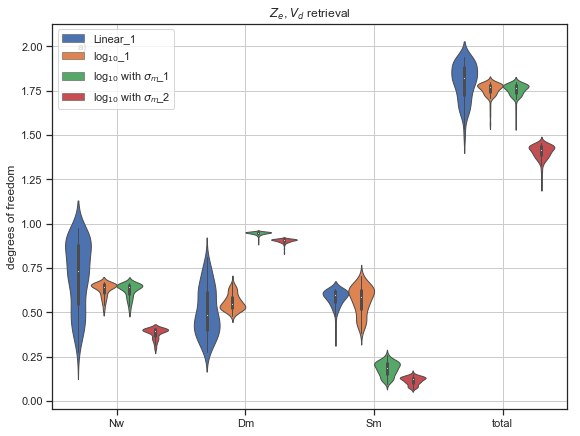

In [41]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):
    sns.violinplot(
        x='x_var_simple',
        y='degrees of freedom',
        hue='x_name',
        data=df.where(df.y_name == y_name),
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

## relative improvement

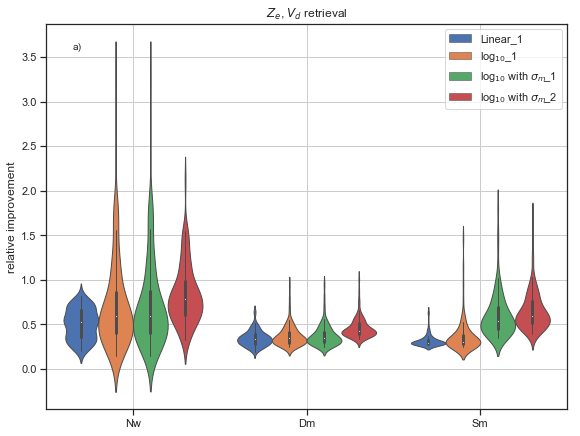

In [42]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):

    sns.violinplot(
        x='x_var_simple',
        y='relative improvement',
        hue='x_name',
        data=df[['x_var_simple','relative improvement','x_name']].where(df.y_name == y_name).dropna(0, how='any'),
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

## quality tests

converged [88.0, 100.0, 100.0]
nonlinearTest [96.5909090909091, 100.0, 100.0]
chi2Test [94.31818181818183, 92.0, 92.0]


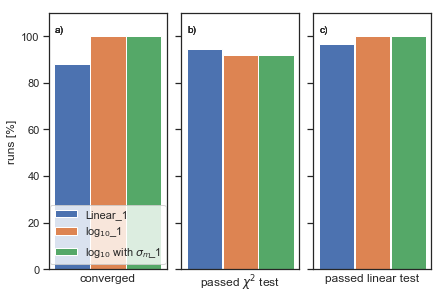

In [43]:
converged = []
nonlinearTest = []
chi2Test = []
# x_names = ['SmLin', 'Sm',  'SmprimeLog10']
# x_names = np.unique((df['x_name']).dropna())
y_name = 'ZW'

x_names1 = [
    'Linear_1', 
            'log$_{10}$_1', 
            'log$_{10}$ with $\\sigma_m\\!$_1'
]

for x_name in x_names1:
    thisII = (df['x_name']==x_name) & (df['y_name']==y_name)
    nSample = (thisII).sum()/4
    converged.append(nSample/nTest * 100)
    nonlinearTest.append(df.where(thisII)['nonlinearTest'].sum()/nSample * 100)
    chi2Test.append((df.where(thisII)['chi2Test'].astype(float)).sum()/nSample * 100)

fig, sps = plt.subplots(ncols=3, sharey=True, figsize=(6,4))
for xx, x_name in enumerate(x_names1):
    sps[0].bar(xx,converged[xx],label=x_name,width=0.98)
    sps[1].bar(xx,chi2Test[xx],label=x_name,width=0.98)
    sps[2].bar(xx,nonlinearTest[xx],label=x_name,width=0.98)

    sps[0].set_xticks([])
    sps[1].set_xticks([])
    sps[2].set_xticks([])
    sps[0].set_xlabel('converged')
    sps[2].set_xlabel('passed linear test')
    sps[1].set_xlabel('passed $\chi^2$ test')




    sps[0].set_ylabel('runs [%]')
    sps[0].set_ylim(0,110)
    sps[0].legend(loc='lower center')
  
    for ii in range(3):
        sps[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sps[ii].transAxes)

fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.)
# fig.savefig('bar_y_%s.pdf'%version)

print('converged', converged)
print('nonlinearTest', nonlinearTest)
print('chi2Test', chi2Test)

In [44]:
df.where(df.nonlinearTest==False).dropna(how='all')

,degrees of freedom,relative error,relative improvement,chi2Test,nonlinearTest,x_var,x_var_simple,y_name,x_name
277,1.598756,NaN,NaN,False,False,total,total,ZW,Linear_1
282,1.484456,NaN,NaN,False,False,total,total,ZW,Linear_1
311,1.908445,NaN,NaN,True,False,total,total,ZW,Linear_1


In [45]:
df

,degrees of freedom,relative error,relative improvement,chi2Test,nonlinearTest,x_var,x_var_simple,y_name,x_name
0,0.602191,0.544629,0.614308,NaN,NaN,Nw,Nw,ZW,Linear_1
1,0.408174,0.422341,0.744826,NaN,NaN,Nw,Nw,ZW,Linear_1
2,0.685074,0.596258,0.548067,NaN,NaN,Nw,Nw,ZW,Linear_1
3,0.915587,0.731951,0.292003,NaN,NaN,Nw,Nw,ZW,Linear_1
4,0.891751,0.710496,0.328933,NaN,NaN,Nw,Nw,ZW,Linear_1
5,0.704744,0.615169,0.530463,NaN,NaN,Nw,Nw,ZW,Linear_1
6,0.857614,0.675833,0.377850,NaN,NaN,Nw,Nw,ZW,Linear_1
7,0.908975,0.711239,0.305988,NaN,NaN,Nw,Nw,ZW,Linear_1
8,0.857018,0.697866,0.398375,NaN,NaN,Nw,Nw,ZW,Linear_1
9,0.923148,0.819530,0.274130,NaN,NaN,Nw,Nw,ZW,Linear_1


In [46]:
np.argmin(np.abs(resultsOE['Linear_ZW_1'].dgf - 1.908445))

<xarray.DataArray 'dgf' ()>
array(47)

In [47]:
resultsOE['Linear_ZW_1'].isel(time=47)

<xarray.Dataset>
Dimensions:                    (chi2test: 4, x_vars: 3, x_vars_T: 3, y_vars: 2, y_vars_T: 2)
Coordinates:
  * x_vars                     (x_vars) object 'Dm' 'Nw' 'Sm'
  * x_vars_T                   (x_vars_T) object 'Dm' 'Nw' 'Sm'
  * y_vars                     (y_vars) object 'Ze_13.6' 'MDV_13.6'
  * y_vars_T                   (y_vars_T) object 'Ze_13.6' 'MDV_13.6'
  * chi2test                   (chi2test) object 'Y_Optimal_vs_Observation' ... 'X_Optimal_vs_Prior'
Data variables:
    x_a                        (x_vars) float64 1.462 4.055e+03 0.5087
    x_a_err                    (x_vars) float64 0.3585 4.273e+03 0.1936
    S_a                        (x_vars, x_vars_T) float64 0.1285 ... 0.03747
    x_op                       (x_vars) float64 1.438 2.155e+03 0.5082
    x_op_err                   (x_vars) float64 0.1318 1.486e+03 0.05374
    S_op                       (x_vars, x_vars_T) float64 0.01736 ... 0.002888
    dgf_x                      (x_vars) float64 0.395